# Graphs

## Warm-up

We start by showing that the same graph can be drawn in various ways. First, we create a simple directed graph with five nodes and six edges.

In [1]:
import itertools as it
import networkx as nx
import pygraphviz as pgv
from nxpd import draw, nxpdParams
nxpdParams['show'] = 'ipynb'

G = nx.DiGraph()
G.add_edges_from([('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'e'), ('e', 'c'), ('a', 'd')])

Now, let's draw it. We first draw it using circular layout.

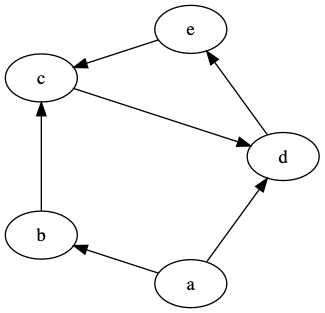

In [2]:
draw(G, layout='circo')

Then, let's use a layered layout.

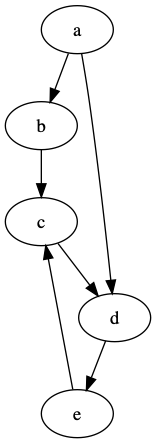

In [3]:
draw(G, layout='dot')

Finally, let's draw it using a different layout.

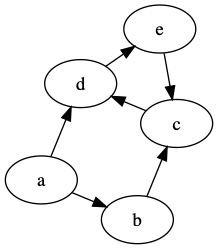

In [4]:
draw(G, layout='neato')

You may now want to go back to the first code block and to fool around with the graph. E.g., try to add new edges to it. To clear all output, use either Kernel -> Restart & Clear Output or Cell -> All output -> Clear.

## Connected Components in Undirected Graphs

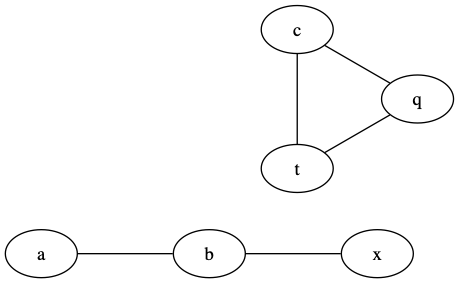

In [5]:
G = nx.Graph()
G.add_edges_from([('a', 'b'), ('t', 'c'), ('b', 'x'), ('c', 'q'), ('q', 't')])
draw(G, layout='circo')

In [6]:
print("G has {} connected components:".format(nx.number_connected_components(G)))
for cc in nx.connected_components(G):
    print(cc)

G has 2 connected components:
{'x', 'b', 'a'}
{'t', 'q', 'c'}


## Eulerian Cycles

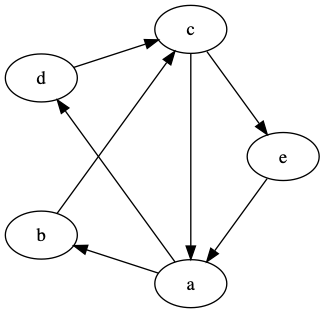

In [7]:
G = nx.DiGraph([('a', 'b'), ('b', 'c'), ('c', 'e'), ('e', 'a'), ('a', 'd'), ('d', 'c'), ('c', 'a')])
draw(G, layout='circo')

In [8]:
if nx.is_eulerian(G):
    cycle = nx.eulerian_circuit(G)
    
    edge_number = 1
    for e in cycle:
        G[e[0]][e[1]]['label'] = str(edge_number)
        edge_number += 1
else:
    print("There is no Eulerian cycle in this graph")

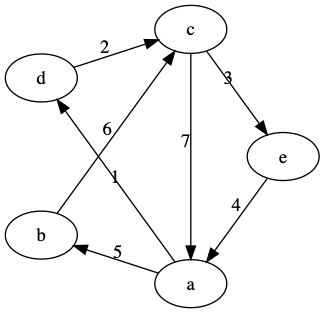

In [9]:
draw(G, layout='circo')

## Guarini Puzzle Solver

In this section, we'll implement a program that we'll solve the [Guarini puzzle](http://dm.compsciclub.ru/app/quiz-guarinis-puzzle) in blink of an eye!

Before starting to implement, let's agree on the following representation of a configuration. First, let's enumerate the eight essential cells of a 3x3 board as follows:

<img src="images/boardnums.png" width="200"/>

By a configuration we mean a placement of two white and two black knight on this board. We will represent it as a string of length eight. Its i-th symbol is equal to "*", if there is no knight in the i-th cell of the board. It is equal to "B" or "W", if the i-th cell contains a black or white knight, respectively. See an example below.

<img src="images/configuration.png" width="200"/>



We now start creating the graph of all configurations. Below, we iterate through all possible strings of length 8 with two W's and two B's. For this, we iterate through all possible four indices of W's and B's (out of eight possible positions).

In [10]:
G = nx.Graph()

for wb_indices in it.permutations(range(8), 4):
    configuration = ['*'] * 8
    configuration[wb_indices[0]] = 'W'
    configuration[wb_indices[1]] = 'W'
    configuration[wb_indices[2]] = 'B'
    configuration[wb_indices[3]] = 'B'

    G.add_node("".join(configuration))

We then add edges to the graph. For this, we first fill in a list moves: moves[i] are the numbers of cells where a knight can move from the i-th cell.

In [11]:
moves = [[] for _ in range(8)]
moves[0] = [4, 6]
moves[1] = [5, 7]
moves[2] = [3, 6]
moves[3] = [2, 7]
moves[4] = [0, 5]
moves[5] = [1, 4]
moves[6] = [0, 2]
moves[7] = [1, 3]

Adding edges to the graph:

In [12]:
for node in G.nodes():
    configuration = [c for c in node]

    for i in range(8):
        if configuration[i] != "*":
            for new_pos in moves[i]:
                if configuration[new_pos] != "*":
                    continue
                new_configuration = list(configuration)

                new_configuration[i] = "*"
                new_configuration[new_pos] = configuration[i]

                if not G.has_edge("".join(configuration), "".join(new_configuration)):
                    G.add_edge("".join(configuration), "".join(new_configuration))

OK, the graph has been cooked! We can now analyze it. Let's first print its number of nodes, number of edges, and number of connected components.

In [13]:
print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))
print(nx.number_connected_components(G))

420
960
2


Well, the fact that the graph has two connected components is not surprising. The eight nodes of a 3x3 board form a cycle. Thus, one connected component contains all configurations where along this cycle two white knights are followed by two black knights, while the other connected components consists of all configurations where the white and black knights are interchanged.

<img src="images/two_configurations.png" width="400"/>

Let’s now ensure that the configurations "W*B**W*B" and "B*B**W*W" are reachable from "W*W**B*B", while "W*B**B*W" is not.

In [14]:
assert "W*B**W*B" in nx.node_connected_component(G, "W*W**B*B")
assert "B*B**W*W" in nx.node_connected_component(G, "W*W**B*B")
assert "W*B**B*W" not in nx.node_connected_component(G, "W*W**B*B")

The number of connected components of the resulting graph of configurations is not the only interesting property! We can now easily find an optimal (i.e., shortest) way of getting from one configuration to another one:

In [15]:
print(" -> ".join(nx.shortest_path(G, "W*W**B*B", "B*B**W*W")))

W*W**B*B -> WBW**B** -> WBW*B*** -> *BW*B*W* -> BBW***W* -> B*W**BW* -> B*W*B*W* -> B**WB*W* -> B*WWB*** -> **WWB*B* -> B*WW**B* -> B*W***BW -> BWW***B* -> BW*W**B* -> BWBW**** -> BWB****W -> B*B**W*W


## 2-Satsifiability Solver

The code below represents a 2-CNF formula $(\bar{x} \lor y) (\bar{y} \lor z) (x \lor \bar{z}) (z \lor y)$ as ```[(-1, 2), (-2, 3), (1, -3), (1, 3)]```.

First, we construct an implication graph.

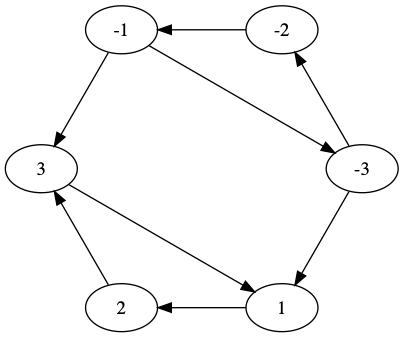

In [16]:
clauses = [(-1, 2), (-2, 3), (1, -3), (1, 3)]

implication_graph = nx.DiGraph(strict=False)
for c in clauses:
    implication_graph.add_edge(-c[0], c[1])
    implication_graph.add_edge(-c[1], c[0])
draw(implication_graph, layout='circo')

In [17]:
scc = list(nx.strongly_connected_components(implication_graph))
print(scc)

[{1, 2, 3}, {-3, -2, -1}]


Now, we are ready to check whether the formula is satisfiable.

In [18]:
if any([any([-l in c for l in c]) for c in scc]):
    print("The formula is unsatisfiable")
else:
    print("The formula is satisfiable")

The formula is satisfiable
